In [1]:
import numpy as np
import pandas as pd
import sys,random,os,csv, random
import matplotlib.pyplot as plt
from collections import defaultdict

# from sklearn.feature_extraction.text import CountVectorizer

In [2]:
def dict_subtract(vec1, vec2):
    """treat vec1 and vec2 as dict representations of sparse vectors"""
    out = defaultdict(float)
    out.update(vec1)
    for k in vec2: out[k] -= vec2[k]
    return dict(out)

def dict_add(vec1, vec2):
    out = defaultdict(float)
    out.update(vec1)
    for k in vec2: out[k] += vec2[k]
    return dict(out)

def dict_dotprod(d1, d2):
    """Return the dot product (aka inner product) of two vectors, where each is
    represented as a dictionary of {index: weight} pairs, where indexes are any
    keys, potentially strings.  If a key does not exist in a dictionary, its
    value is assumed to be zero."""
    smaller = d1 if len(d1)<len(d2) else d2  # BUGFIXED 20151012
    total = 0
    for key in smaller.keys():
        total += d1.get(key,0) * d2.get(key,0)
    return total

def dict_const_mult(vec, const):
    out = defaultdict(float)
    out.update(vec)
    for k in vec: out[k] = out[k] * const
    return dict(out)

def dict_argmax(dct):
    return max(dct.keys(), key=lambda k: dct[k])

In [17]:
def plot_accuracy_vs_iteration(accuracies, num_iter):
    plt.plot(range(num_iter), accuracies)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Num. iterations vs Accuracy')
    plt.show()
    
def plot_label_stats(label_counts):
#     sum = 0
#     for k in label_counts.keys():
#         sum += label_counts[k]
        
    labels = []
    counts = []
    for k in label_counts.keys():
        labels.append(k)
        counts.append(label_counts[k])
        
    print(labels)
    print(counts)
    print()
    print()
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.show()

In [4]:
class Perceptron(object):
    
    def __init__(self, eta=0.01, n_iter=50):
        self.eta = eta #learning rate eta
        self.n_iter = n_iter #number of epochs (passes)
        self._weights = defaultdict(float)
        
    def fit(self, train_tweets, gold_labels, test_tweets=None, test_gold_labels=None):
        
        # self._errors = [] # array of misclassifications in every epoch (pass)
        accuracies = []
        train_data = [(t, l) for t, l in zip(train_tweets, gold_labels)]
        for i in range(self.n_iter):
            random.shuffle(train_data)
            for tweet, gold_label in train_data:
                predict_label = self.predict(tweet)
                
                if predict_label != gold_label:
                    pred_feats = features_per_tweet(tweet, predict_label)
                    gold_feats = features_per_tweet(tweet, gold_label)
                    
                    diff_feats = dict_subtract(gold_feats, pred_feats)
                    update = dict_const_mult(diff_feats, self.eta)
                    self._weights.update(dict_add(self._weights, update))
                
            print()
            print()
            print("Iter. ", i, " - TRAIN RAW EVAL")
            accuracy = self.do_evaluation(train_tweets, gold_labels)
            accuracies.append(accuracy)
            if test_tweets and test_gold_labels:
                print("Iter. ", i, " - TEST  RAW EVAL")
                self.do_evaluation(test_tweets, test_gold_labels)
                
        plot_accuracy_vs_iteration(accuracies, self.n_iter)
        return self
    
    def do_evaluation(self, tweets, labels):
        num_correct, num_total = 0,0
        for tweet, label in zip(tweets, labels):
            predict_label = self.predict(tweet)
            num_correct += 1 if predict_label == label else 0
            num_total += 1
        print("%d/%d = %.4f accuracy" % (num_correct, num_total, num_correct/num_total))
        return num_correct/num_total
        
    def predict(self, tweet):
        # "one-vs-all" strategy later
        label_dict = {}
        hillary_features = features_per_tweet(tweet, "Hillary Clinton")
        hillary_linear_comb = dict_dotprod(hillary_features, self._weights)
        label_dict["Hillary Clinton"] = hillary_linear_comb
        
        atheism_features = features_per_tweet(tweet, "Atheism")
        atheism_linear_comb = dict_dotprod(hillary_features, self._weights)
        label_dict["Atheism"] = atheism_linear_comb
        
        climate_features = features_per_tweet(tweet, "Climate Change is a Real Concern")
        climate_linear_comb = dict_dotprod(hillary_features, self._weights)
        label_dict["Climate Change is a Real Concern"] = climate_linear_comb
        
        donald_features = features_per_tweet(tweet, "Donald Trump")
        donald_linear_comb = dict_dotprod(hillary_features, self._weights)
        label_dict["Donald Trump"] = donald_linear_comb
        
        feminist_features = features_per_tweet(tweet, "Feminist Movement")
        feminist_linear_comb = dict_dotprod(hillary_features, self._weights)
        label_dict["Feminist Movement"] = feminist_linear_comb
        
        abortion_features = features_per_tweet(tweet, "Legalization of Abortion")
        abortion_linear_comb = dict_dotprod(hillary_features, self._weights)
        label_dict["Legalization of Abortion"] = abortion_linear_comb
        
        return dict_argmax(label_dict)
    
#         if hillary_linear_comb > len(tweet):
#             return "Hillary Clinton"
#         elif atheism_linear_comb > len(tweet):
#             return "Atheism"
#         elif climate_linear_comb > len(tweet):
#             return "Climate Change is a Real Concern"
#         elif feminist_linear_comb > len(tweet):
#             return "Feminist Movement"
#         elif abortion_linear_comb > len(tweet):
#             return "Legalization of Abortion"
#         else:
#             return "Donald Trump"
        
                                                                 

In [5]:
def features_per_tweet(tweet, label):
    features = {}
    # Tokenize tweet
    tweet_tokens = tweet.lower().split()
    for token in tweet_tokens:
        if token not in features:
            features[token] = 1
        else:
            features[token] += 1
            
        if "token=%s_label=%s" % (token, label) not in features:
            features["token=%s_label=%s" % (token, label)] = 5
        else:
            features["token=%s_label=%s" % (token, label)] += 1    
    return features

In [6]:
def process_csv(csv_file_path, start=None, end=None):
    tweets, gold_labels = [], []
    label_counts = {
        "Hillary Clinton": 0,
        "Atheism": 0,
        "Climate Change is a Real Concern": 0,
        "Feminist Movement": 0,
        "Legalization of Abortion": 0,
        "Donald Trump": 0
    }
    
    with open(csv_file_path, 'r', encoding='utf-8', errors='ignore') as csv_file:
        csv_reader = csv.reader(csv_file)
        size = sum(1 for _ in csv_reader)
        print("File size: ", size)
        csv_file.seek(0)
        
        csv_reader = csv.reader(csv_file)
        next(csv_reader)
        
        f = start if start else 0
        t = end if end else size-1
        for i in range(f, t):
            row = next(csv_reader)
            tweets.append(row[0]) # row[0] is tweet
            gold_labels.append(row[1]) # row[1] is label
            label_counts[row[1]] += 1
            
#         for row in csv_reader:
#             tweet = row[0]
#             tweets.append(tweet)
#             gold_label = row[1]
#             gold_labels.append(gold_label)
    return tweets, gold_labels, label_counts

File size:  1957
['Donald Trump', 'Climate Change is a Real Concern', 'Atheism', 'Feminist Movement', 'Hillary Clinton', 'Legalization of Abortion']
[707, 169, 220, 285, 295, 280]




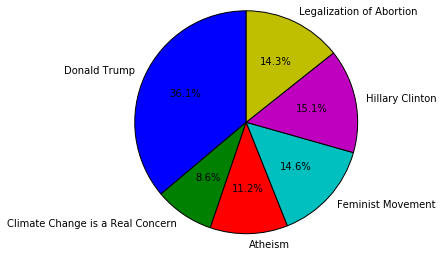

In [20]:
path = os.getcwd()
path = os.path.join(path, "StanceDataset")
train_path = os.path.join(path, "train.csv")
test_path = os.path.join(path, "test.csv")

train_tweets, train_gold_labels, train_label_counts = process_csv(test_path)
# test_tweets, test_gold_labels, test_label_counts = process_csv(test_path, start=0, end=98)

ppn = Perceptron()
# ppn.fit(train_tweets, train_gold_labels)

plot_label_stats(train_label_counts)
            